In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fourier_features.plot import AirPlot, PlotData, AxParams, FigParams

## Dataset
### Airline passengers by month, 1949 to 1960

In [13]:
df = pd.read_csv("data.csv").rename(columns={'Passengers': 'passengers', 'Month': 'month'})
df['month'] = pd.to_datetime(df['month'])
df['mth_idx'] = 12 * df['month'].dt.year + df['month'].dt.month
df['n_months'] = (df['mth_idx'] - df['mth_idx'].min()) + 1
df = df.drop(columns=['mth_idx'])
df['log_passengers'] = np.log(df['passengers'])
df = df['month passengers n_months log_passengers'.split()].rename(columns={
    'month': 'Date',
    'passengers': 'Number of Passengers'})
df.head()

,Date,Number of Passengers,n_months,log_passengers
0,1949-01-01,112,1,4.718499
1,1949-02-01,118,2,4.770685
2,1949-03-01,132,3,4.882802
3,1949-04-01,129,4,4.859812
4,1949-05-01,121,5,4.795791


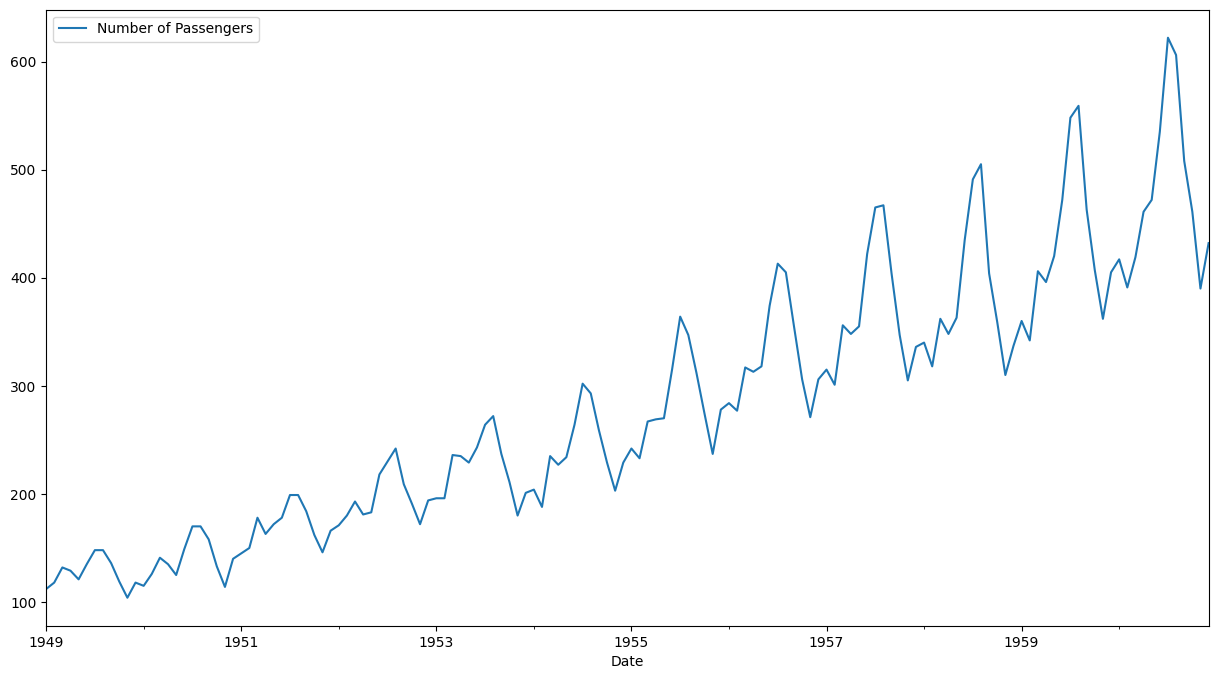

In [19]:
fig, ax = plt.subplots(figsize=(15, 8))
df[['Date', 'Number of Passengers']].set_index('Date').plot(kind='line', ax=ax);

## 80-20 train/test split

In [20]:
def get_80pct_of_data_points(df):
    """Returns a dataframe with 80% of the data points."""
    return df.iloc[: int(len(df) * 0.8)]

def get_other_20pct_of_data_points(df):
    """Returns a dataframe with the complement of the 80% of the data points."""
    return df.iloc[int(len(df) * 0.8) :]

print(f"n data points: {len(df)}")
print(f"Training set contains: {get_80pct_of_data_points(df).shape[0]}")
print(f"Testing set contains: {get_other_20pct_of_data_points(df).shape[0]}")

n data points: 144
Training set contains: 115
Testing set contains: 29


## Make X and y datasets

In [36]:
xcol, ycol = 'n_months', 'Number of Passengers'
X, y = df[xcol], df[ycol]

X_train, y_train, dates_train = (
    get_80pct_of_data_points(df)[xcol],
    get_80pct_of_data_points(df)[ycol],
    get_80pct_of_data_points(df)['Date']
)
X_test, y_test, dates_test = (
    get_other_20pct_of_data_points(df)[xcol],
    get_other_20pct_of_data_points(df)[ycol],
    get_other_20pct_of_data_points(df)['Date']
)
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((115, 1), (115,), (29, 1), (29,))

## Fit basic linear regression model

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)
yhat_train1 = lr.predict(X_train)
yhat_test1 = lr.predict(X_test)

mse_train = mean_squared_error(y_train, yhat_train1)
mse_test = mean_squared_error(y_test, yhat_test1)

print(f"R2 Train: {r2_score(y_train, yhat_train1):.1%} | R2 Test: {r2_score(y_test, yhat_test1):.1%}")
print(f"MAPE Train: {mean_absolute_percentage_error(y_train, yhat_train1):.1%} | MAPE Test: {mean_absolute_percentage_error(y_test, yhat_test1):.1%}")
print(f"RMSE Train: {root_mean_squared_error(y_train, yhat_train1):.1f} | RMSE Test: {root_mean_squared_error(y_test, yhat_test1):.1f}")
yhat_train.shape, yhat_test1.shape

R2 Train: 84.2% | R2 Test: 10.8%
MAPE Train: 11.6% | MAPE Test: 12.1%
RMSE Train: 36.2 | RMSE Test: 73.8


((115,), (29,))

## Check fit

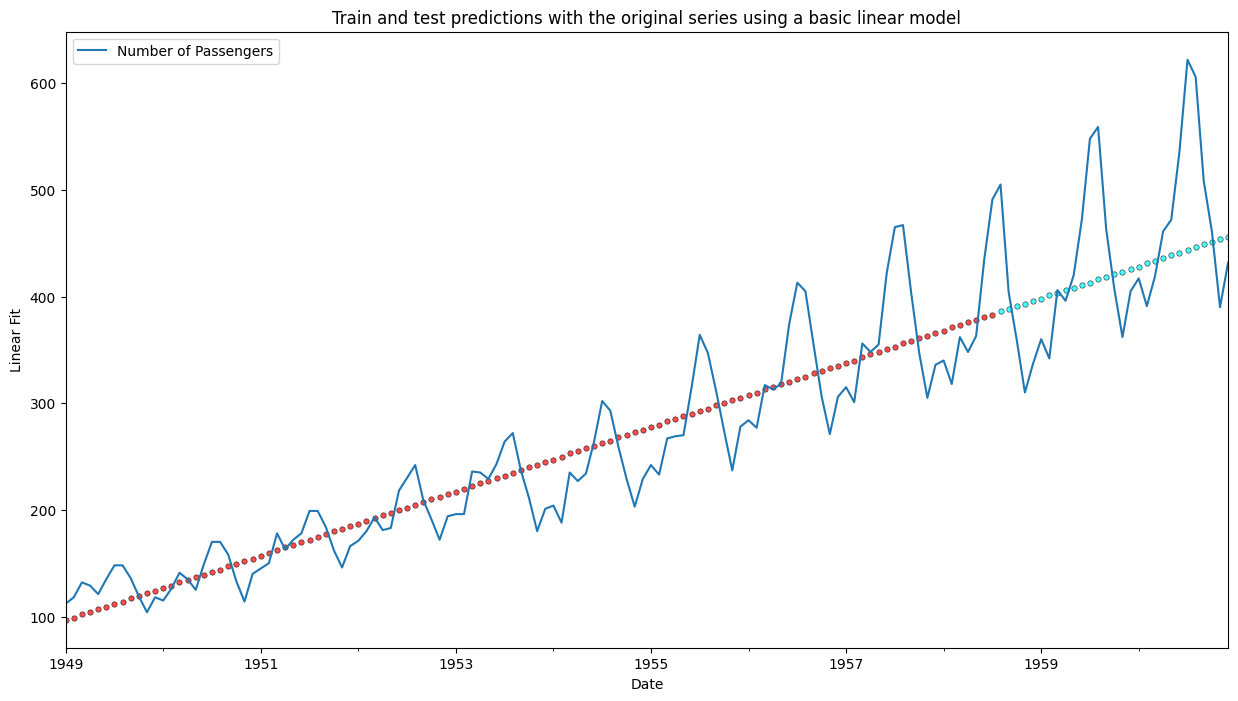

In [59]:
_params = {'s': 15, 'marker': 'o', 'alpha': 0.7, 'edgecolors': 'black', 'linewidth': 0.5}
fig, ax = plt.subplots(figsize=(15, 8))
plotdat = df[['Date', 'Number of Passengers']].set_index('Date')
plotdat['Number of Passengers'].astype(float)
plotdat.plot(kind='line', ax=ax)

pd.DataFrame({'Date': dates_train,'Linear Fit': yhat_train1.round(0).astype(int)}).plot(kind='scatter', x='Date', y='Linear Fit', c='red', ax=ax, **_params)
pd.DataFrame({'Date': dates_test,'Linear Fit': yhat_test1.round(0).astype(int)}).plot(kind='scatter', x='Date', y='Linear Fit', c='cyan', ax=ax, **_params)
ax.set_title("Train and test predictions with the original series using a basic linear model")
plt.show()

### Log-linear model

In [60]:
lr = LinearRegression()
lr.fit(X_train, np.log(y_train))
yhat_train2 = np.exp(lr.predict(X_train))
yhat_test2 = np.exp(lr.predict(X_test))

mse_train2 = mean_squared_error(y_train, yhat_train2)
mse_test2 = mean_squared_error(y_test, yhat_test2)

print(f"MAPE Train: {mean_absolute_percentage_error(y_train, yhat_train2):.1%} | MAPE Test: {mean_absolute_percentage_error(y_test, yhat_test2):.1%}")
print(f"RMSE Train: {root_mean_squared_error(y_train, yhat_train2):.1f} | RMSE Test: {root_mean_squared_error(y_test, yhat_test2):.1f}")
yhat_train.shape, yhat_test2.shape

R2 Train: 85.1% | R2 Test: -20.9%
MAPE Train: 10.7% | MAPE Test: 18.6%
RMSE Train: 35.1 | RMSE Test: 85.9


((115,), (29,))

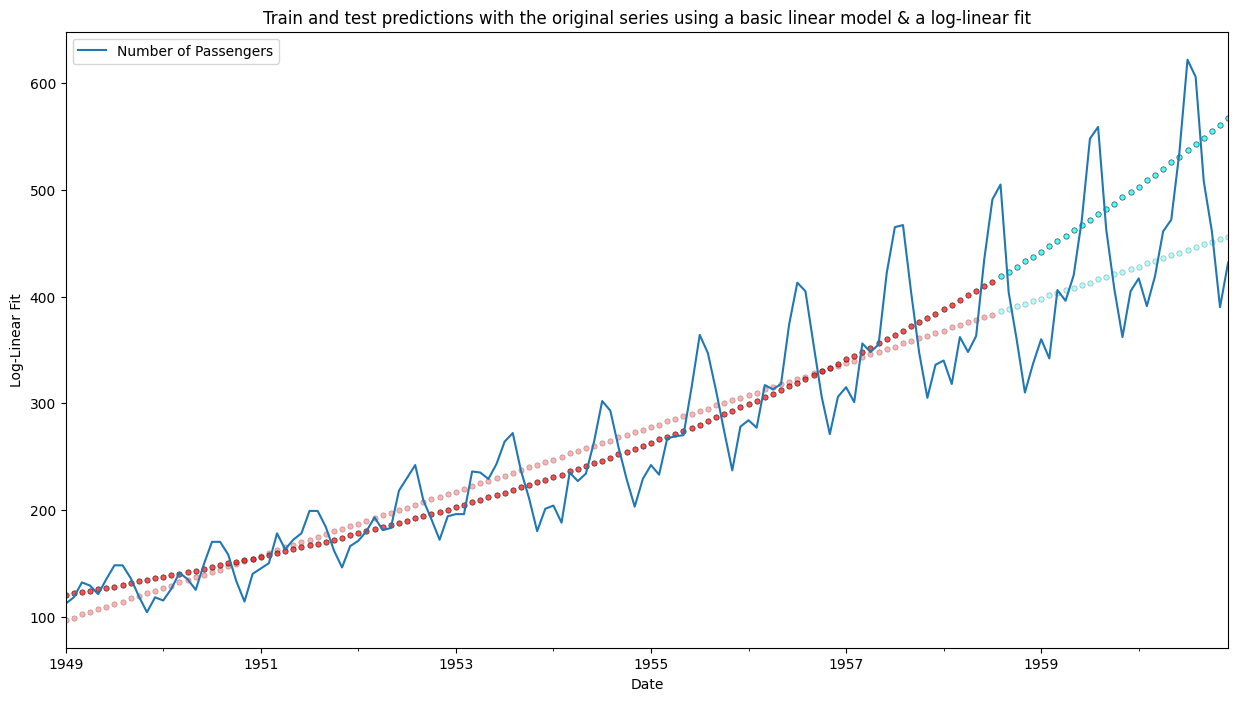

In [65]:
_params = {'s': 15, 'marker': 'o', 'edgecolors': 'black', 'linewidth': 0.5}
fig, ax = plt.subplots(figsize=(15, 8))
plotdat = df[['Date', 'Number of Passengers']].set_index('Date')
plotdat['Number of Passengers'].astype(float)
plotdat.plot(kind='line', ax=ax)

pd.DataFrame({'Date': dates_train,'Linear Fit': yhat_train1.round(0).astype(int)}).plot(alpha=0.3, kind='scatter', x='Date', y='Linear Fit', c='red', ax=ax, **_params)
pd.DataFrame({'Date': dates_test,'Linear Fit': yhat_test1.round(0).astype(int)}).plot(alpha=0.3, kind='scatter', x='Date', y='Linear Fit', c='cyan', ax=ax, **_params)

pd.DataFrame({'Date': dates_train,'Log-Linear Fit': yhat_train2.round(0).astype(int)}).plot(alpha=0.7, kind='scatter', x='Date', y='Log-Linear Fit', c='red', ax=ax, **_params)
pd.DataFrame({'Date': dates_test,'Log-Linear Fit': yhat_test2.round(0).astype(int)}).plot(alpha=0.7, kind='scatter', x='Date', y='Log-Linear Fit', c='cyan', ax=ax, **_params)

ax.set_title("Train and test predictions with the original series using a basic linear model & a log-linear fit")
plt.show()

### Fourier features

For feature vector $X$, augment $X$ with:
$$
\left\{
\begin{array}
\text{cos}\left(\frac{2\pi X}{T}\right) \\
\text{sin}\left(\frac{2\pi X}{T}\right)
\end{array}
\right.
$$

In [68]:
twopi = 2 * np.pi
fourier_train = np.hstack([np.sin(twopi * X_train / 12),np.cos(twopi * X_train / 12)])
fourier_test = np.hstack([np.sin(twopi * X_test / 12),np.cos(twopi * X_test / 12)])

fourier_train[:5], fourier_test[:5]

(array([[ 5.00000000e-01,  8.66025404e-01],
        [ 8.66025404e-01,  5.00000000e-01],
        [ 1.00000000e+00,  6.12323400e-17],
        [ 8.66025404e-01, -5.00000000e-01],
        [ 5.00000000e-01, -8.66025404e-01]]),
 array([[-8.66025404e-01, -5.00000000e-01],
        [-1.00000000e+00, -4.16441810e-15],
        [-8.66025404e-01,  5.00000000e-01],
        [-5.00000000e-01,  8.66025404e-01],
        [-9.55472096e-15,  1.00000000e+00]]))

In [69]:
lr = LinearRegression()
xtrain = np.hstack(
    [
        X_train,
        fourier_train,
    ]
)
xtest = np.hstack(
    [
        X_test,
        fourier_test,
    ]
)
lr.fit(xtrain, np.log(y_train))

yhat_train3 = np.exp(lr.predict(xtrain))
yhat_test3 = np.exp(lr.predict(xtest))

mse_train = mean_squared_error(y_train, yhat_train)
mse_test = mean_squared_error(y_test, yhat_test)
yhat_train3.shape, yhat_test3.shape

((115,), (29,))

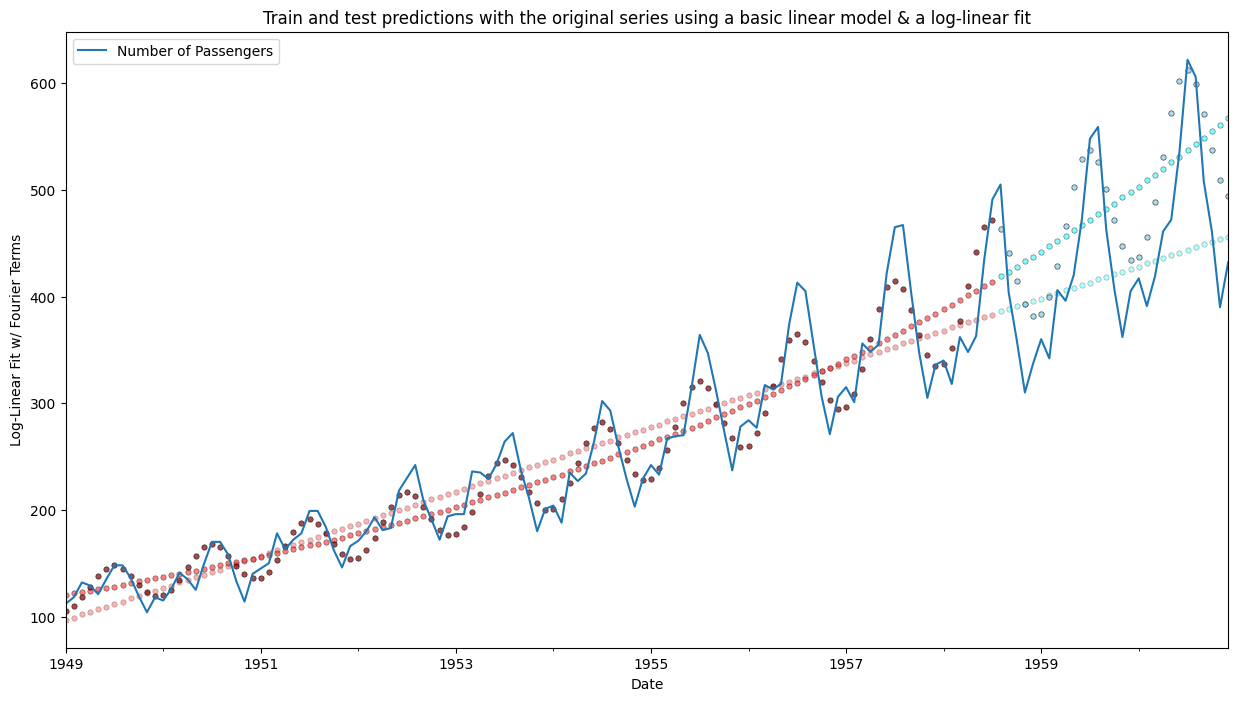

In [72]:
_params = {'s': 15, 'marker': 'o', 'edgecolors': 'black', 'linewidth': 0.5}
fig, ax = plt.subplots(figsize=(15, 8))
plotdat = df[['Date', 'Number of Passengers']].set_index('Date')
plotdat['Number of Passengers'].astype(float)
plotdat.plot(kind='line', ax=ax)

pd.DataFrame({'Date': dates_train,'Linear Fit': yhat_train1.round(0).astype(int)}).plot(alpha=0.3, kind='scatter', x='Date', y='Linear Fit', c='red', ax=ax, **_params)
pd.DataFrame({'Date': dates_test,'Linear Fit': yhat_test1.round(0).astype(int)}).plot(alpha=0.3, kind='scatter', x='Date', y='Linear Fit', c='cyan', ax=ax, **_params)

pd.DataFrame({'Date': dates_train,'Log-Linear Fit': yhat_train2.round(0).astype(int)}).plot(alpha=0.5, kind='scatter', x='Date', y='Log-Linear Fit', c='red', ax=ax, **_params)
pd.DataFrame({'Date': dates_test,'Log-Linear Fit': yhat_test2.round(0).astype(int)}).plot(alpha=0.5, kind='scatter', x='Date', y='Log-Linear Fit', c='cyan', ax=ax, **_params)

yh='Log-Linear Fit w/ Fourier Terms'
pd.DataFrame({'Date': dates_train, yh: yhat_train3.round(0).astype(int)}).plot(alpha=0.7, kind='scatter', x='Date', y=yh, c='maroon', ax=ax, **_params)
pd.DataFrame({'Date': dates_test, yh: yhat_test3.round(0).astype(int)}).plot(alpha=0.7, kind='scatter', x='Date', y=yh, c='skyblue', ax=ax, **_params)

ax.set_title("Train and test predictions with the original series using a basic linear model & a log-linear fit")
plt.show()